In [1]:
import itertools as it
import os
import pandas as pd
import numpy as np
import random
import vitaldb
#from pyvital2 import arr
from pyvital.pyvital import arr
import pickle
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import time, datetime


SRATE = 100
LEN_INPUT = 60
OVERLAP = 10
LEN_PER_PRE = 60
LEN_PER_POST = 60

file_path = 'vital_to_np'


# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)

def lowess(y, f=0.2):
    x = np.arange(0, len(y))
    return sm.nonparametric.lowess(y, x, frac=f, it=0)[:, 1].T
## 60초짜리 inputp에 대해 f 그려보기


print(datetime.datetime.now())

2022-11-01 09:58:22.201613


# Download vital data

In [ ]:
file_path = 'vital_to_np_pd'

print('loading vital data...')
start = time.time()

# tracks to extract / VENT_SET_TV -> VENT_INSP_TM, SET_INSP_TM
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE", "Solar8000/NIBP_MBP", "Solar8000/ART_MBP", "Solar8000/HR", "Solar8000/ETCO2"]

# create saving folder
#file_path = "vital_to_np"
if not os.path.exists(file_path):
    os.mkdir(file_path)

# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")

# target patients' caseids
caseids = list(vitaldb.caseids_tiva & set(df.loc[df['ane_type'] == 'General', 'caseid']))


cnt = 0
non_intu, non_mbp, non_hr, emptyCO2 = [], [], [], []
for caseid in caseids:
    cnt = cnt + 1
    print(f'{cnt}/{len(caseids)}({caseid})', end='...')

    # check if file is already existing
    filename = f'{file_path}/{caseid}.npz'
    if os.path.isfile(filename):
        print('already existing')
        continue


    # get vital file and save as numpy
    vf = vitaldb.VitalFile(caseid, track_names)
    vals = vf.to_numpy(track_names, interval=1/SRATE)

    # intubation time - find the first t which satisfies vent_set_tm != nan & ppf_ce != nan
    t_intu = np.where(~np.isnan(vals[:,5]))[0][0]

    if not np.mean(~np.isnan(vals[:,2])):
        if not np.mean(~np.isnan(vals[:,3])):
            print(f'no valid data for insp_tm')

        intu = vals[:,3]
        intv = 850 # maximum interval for "Primus/SET_INSP_TM"
    else:
        intu = vals[:,2]
        intv = 250 # maximum interval for "Solar8000/VENT_INSP_TM"

    idc_intu = np.where(~np.isnan(intu))[0]
    while True:
        if t_intu >= len(vals[:,0]):
            non_intu.append(caseid)
            print('no valid intubation time')
            break

        # vent_insp_tm이 nan이 아닌 경우
        if not np.isnan(intu[t_intu]):
            idx = np.where(idc_intu==t_intu)[0][0]
            if idx + 10 >= len(idc_intu):
                non_intu.append(caseid)
                print('...no valid intubation time')
                break                
            prev = t_intu

            # 모여있는 vent_insp_tm 길이 계산
            switch = True
            for i in range(1,11):
                if idc_intu[idx+i] - prev > intv:
                    switch = False
                prev = idc_intu[idx+i]

            if switch:
                break
                # 초반에 vent_insp_tm이 예외적으로 측정된 경우 제외    
                # if abs(t_intu-t_etco2) < 5.5*60*SRATE:
                #    break
                # else:
                #    t_intu += 1
            else:
                t_intu += 1
        else:
            t_intu += 1


    # MBP value
    if not np.mean(~np.isnan(vals[:,6])):
        if not np.mean(~np.isnan(vals[:,7])):
            non_mbp.append(caseid)
            print(f'no valid data for MBP')
    nibp = vals[:,6]
    art = vals[:,7]
    mbp = np.array([art[i] if art[i]>30 else nibp[i] for i in range(len(nibp))])

    # HR
    if not np.mean(~np.isnan(vals[:,8])):
        non_hr.append(caseid)
        print('no valid data for HR')
    hr = vals[:,8]

    # non-event data : extract vital from previous 120s-60s from intubation
    ppg = vals[:,1]
    prev_ppg = ppg[t_intu - SRATE*120:t_intu - SRATE*60]

    ecg = vals[:,0]
    prev_ecg = ecg[t_intu - SRATE*120:t_intu - SRATE*60]

    nppf = vals[:,4]
    nppf = nppf[t_intu - SRATE*120:t_intu - SRATE*60]

    nrftn = vals[:,5]
    nrftn = nrftn[t_intu - SRATE*120:t_intu - SRATE*60]

    nmbp = mbp[t_intu - SRATE*120:t_intu - SRATE*60]
    nhr = hr[t_intu - SRATE*120:t_intu - SRATE*60]

    # after intubation, pain calculated using TSS, CISA
    post_ppg = ppg[t_intu:t_intu + SRATE*LEN_PER_POST]
    post_ecg = ecg[t_intu:t_intu + SRATE*LEN_PER_POST]

    ppf = vals[:,4]
    ppf = ppf[t_intu:t_intu + SRATE*LEN_PER_POST]

    rftn = vals[:,5]
    rftn = rftn[t_intu:t_intu + SRATE*LEN_PER_POST]

    embp = mbp[t_intu:t_intu + SRATE*LEN_PER_POST]
    ehr = hr[t_intu:t_intu + SRATE*LEN_PER_POST]

    np.savez(filename, nECG=prev_ecg, nPPG=prev_ppg, ECG=post_ecg, PPG=post_ppg, nPPF = nppf, nRFTN = nrftn, PPF=ppf, RFTN=rftn, nMBP=nmbp, MBP=embp, nHR=nhr, HR=ehr)
    print('  completed')

end = time.time()
f = open(f'{file_path}/README.txt', 'w')
f.write(f'no valid intubation time: {non_intu}\n')
f.write(f'no valid MBP: {non_mbp}\n')
f.write(f'no valid HR: {non_hr}\n')
#f.write(f'empty ETCO2: {emptyCO2}\n')
f.write(f'total time: {end-start:.2f} sec')
f.close()

loading vital data...
1/2699(3)...already existing
2/2699(8)...already existing
3/2699(9)...already existing
4/2699(13)...already existing
5/2699(14)...already existing
6/2699(16)...already existing
7/2699(17)...already existing
8/2699(19)...already existing
9/2699(20)...already existing
10/2699(22)...already existing
11/2699(28)...already existing
12/2699(29)...already existing
13/2699(30)...already existing
14/2699(35)...already existing
15/2699(36)...already existing
16/2699(40)...already existing
17/2699(42)...already existing
18/2699(44)...already existing
19/2699(45)...already existing
20/2699(46)...already existing
21/2699(47)...already existing
22/2699(48)...already existing
23/2699(50)...already existing
24/2699(54)...already existing
25/2699(57)...already existing
26/2699(59)...already existing
27/2699(67)...already existing
28/2699(69)...already existing
29/2699(70)...already existing
30/2699(72)...already existing
31/2699(74)...already existing
32/2699(75)...already existin

## modification (22/11/01) : SRATE 100 -> 300

In [ ]:
SRATE = 300
file_path = 'vital_to_np_pd_SRATE300'

print('loading vital data...')
start = time.time()

# tracks to extract / VENT_SET_TV -> VENT_INSP_TM, SET_INSP_TM
track_names = ["SNUADC/ECG_II", "SNUADC/PLETH", "Solar8000/VENT_INSP_TM", "Primus/SET_INSP_TM", "Orchestra/PPF20_CE", "Orchestra/RFTN20_CE", "Solar8000/NIBP_MBP", "Solar8000/ART_MBP", "Solar8000/HR", "Solar8000/ETCO2"]

# create saving folder
#file_path = "vital_to_np"
if not os.path.exists(file_path):
    os.mkdir(file_path)

# dataframe of patient information    
df = pd.read_csv("https://api.vitaldb.net/cases")

# target patients' caseids
caseids = list(vitaldb.caseids_tiva & set(df.loc[df['ane_type'] == 'General', 'caseid']))


cnt = 0
non_intu, non_mbp, non_hr, emptyCO2 = [], [], [], []
for caseid in caseids:
    cnt = cnt + 1
    print(f'{cnt}/{len(caseids)}({caseid})', end='...')

    # check if file is already existing
    filename = f'{file_path}/{caseid}.npz'
    if os.path.isfile(filename):
        print('already existing')
        continue


    # get vital file and save as numpy
    vf = vitaldb.VitalFile(caseid, track_names)
    vals = vf.to_numpy(track_names, interval=1/SRATE)

    # intubation time - find the first t which satisfies vent_set_tm != nan & ppf_ce != nan
    t_intu = np.where(~np.isnan(vals[:,5]))[0][0]

    if not np.mean(~np.isnan(vals[:,2])):
        if not np.mean(~np.isnan(vals[:,3])):
            print(f'no valid data for insp_tm')

        intu = vals[:,3]
        intv = 850 *(SRATE/100)  # maximum interval for "Primus/SET_INSP_TM"
    else:
        intu = vals[:,2]
        intv = 250 *(SRATE/100)  # maximum interval for "Solar8000/VENT_INSP_TM"

    idc_intu = np.where(~np.isnan(intu))[0]
    while True:
        if t_intu >= len(vals[:,0]):
            non_intu.append(caseid)
            print('no valid intubation time')
            break

        # vent_insp_tm이 nan이 아닌 경우
        if not np.isnan(intu[t_intu]):
            idx = np.where(idc_intu==t_intu)[0][0]
            if idx + 10*(SRATE/100) >= len(idc_intu):
                non_intu.append(caseid)
                print('...no valid intubation time')
                break                
            prev = t_intu

            # 모여있는 vent_insp_tm 길이 계산
            switch = True
            for i in range(1,11):
                if idc_intu[idx+i] - prev > intv:
                    switch = False
                prev = idc_intu[idx+i]

            if switch:
                break
                # 초반에 vent_insp_tm이 예외적으로 측정된 경우 제외    
                # if abs(t_intu-t_etco2) < 5.5*60*SRATE:
                #    break
                # else:
                #    t_intu += 1
            else:
                t_intu += 1
        else:
            t_intu += 1


    # MBP value
    if not np.mean(~np.isnan(vals[:,6])):
        if not np.mean(~np.isnan(vals[:,7])):
            non_mbp.append(caseid)
            print(f'no valid data for MBP')
    nibp = vals[:,6]
    art = vals[:,7]
    mbp = np.array([art[i] if art[i]>30 else nibp[i] for i in range(len(nibp))])

    # HR
    if not np.mean(~np.isnan(vals[:,8])):
        non_hr.append(caseid)
        print('no valid data for HR')
    hr = vals[:,8]

    # non-event data : extract vital from previous 120s-60s from intubation
    ppg = vals[:,1]
    prev_ppg = ppg[t_intu - SRATE*120:t_intu - SRATE*60]

    ecg = vals[:,0]
    prev_ecg = ecg[t_intu - SRATE*120:t_intu - SRATE*60]

    nppf = vals[:,4]
    nppf = nppf[t_intu - SRATE*120:t_intu - SRATE*60]

    nrftn = vals[:,5]
    nrftn = nrftn[t_intu - SRATE*120:t_intu - SRATE*60]

    nmbp = mbp[t_intu - SRATE*120:t_intu - SRATE*60]
    nhr = hr[t_intu - SRATE*120:t_intu - SRATE*60]

    # after intubation, pain calculated using TSS, CISA
    post_ppg = ppg[t_intu:t_intu + SRATE*LEN_PER_POST]
    post_ecg = ecg[t_intu:t_intu + SRATE*LEN_PER_POST]

    ppf = vals[:,4]
    ppf = ppf[t_intu:t_intu + SRATE*LEN_PER_POST]

    rftn = vals[:,5]
    rftn = rftn[t_intu:t_intu + SRATE*LEN_PER_POST]

    embp = mbp[t_intu:t_intu + SRATE*LEN_PER_POST]
    ehr = hr[t_intu:t_intu + SRATE*LEN_PER_POST]

    np.savez(filename, nECG=prev_ecg, nPPG=prev_ppg, ECG=post_ecg, PPG=post_ppg, nPPF = nppf, nRFTN = nrftn, PPF=ppf, RFTN=rftn, nMBP=nmbp, MBP=embp, nHR=nhr, HR=ehr)
    print('  completed')

end = time.time()
f = open(f'{file_path}/README.txt', 'w')
f.write(f'no valid intubation time: {non_intu}\n')
f.write(f'no valid MBP: {non_mbp}\n')
f.write(f'no valid HR: {non_hr}\n')
#f.write(f'empty ETCO2: {emptyCO2}\n')
f.write(f'total time: {end-start:.2f} sec')
f.close()

loading vital data...
1/2699(3)...  completed
2/2699(8)...  completed
3/2699(9)...  completed
4/2699(13)...  completed
5/2699(14)...  completed
6/2699(16)...  completed
7/2699(17)...  completed
8/2699(19)...  completed
9/2699(20)...  completed
10/2699(22)...  completed
11/2699(28)...  completed
12/2699(29)...  completed
13/2699(30)...  completed
14/2699(35)...  completed
15/2699(36)...  completed
16/2699(40)...  completed
17/2699(42)...  completed
18/2699(44)...  completed
19/2699(45)...  completed
20/2699(46)...  completed
21/2699(47)...  completed
22/2699(48)...  completed
23/2699(50)...  completed
24/2699(54)...  completed
25/2699(57)...  completed
26/2699(59)...  completed
27/2699(67)...  completed
28/2699(69)...  completed
29/2699(70)...  completed
30/2699(72)...  completed
31/2699(74)...  completed
32/2699(75)...  completed
33/2699(77)...  completed
34/2699(78)...  completed
35/2699(83)...  completed
36/2699(88)...  completed
37/2699(93)...  completed
38/2699(101)...  completed
3

# Preprocessing

In [4]:
# path for cache
if not os.path.exists('./cache'):
    os.mkdir('./cache')
if not os.path.exists('./cache/peaks'):
    os.mkdir('./cache/peaks')
if not os.path.exists(f"cache/peaks/PPG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/PPG_{SRATE}Hz_1min_seg")
if not os.path.exists(f"cache/peaks/ECG_{SRATE}Hz_1min_seg"):
    os.mkdir(f"cache/peaks/ECG_{SRATE}Hz_1min_seg")        
if not os.path.exists('./cache/preprocess'):
    os.mkdir('./cache/preprocess')


# dataframe to save preprocessing info
column_list = ['caseid'] + ['1', '2']
df_preprocess = pd.DataFrame(columns = column_list)


# set variables
caseids = os.listdir(file_path)
error_list = []
f_num = 0
initial = f_num
interval = len(caseids)

  
for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    if not np.mean(~np.isnan(vals['RFTN'])):
        print('no RFTN value')
        continue

    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    
    ecg_cache2 = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid

    
    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_b60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_b60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_b60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = sorted(list(set(ecg_peak)))


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_b60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_b60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    ##########################################################################


    ### after intubation event (0 ~ +60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['PPG']
        seg_ecg = vals['ECG']

        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection (b60s : before 60s)
        if os.path.exists(ppg_cache+'_a60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_a60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_a60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = sorted(list(set(ecg_peak)))


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_a60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_a60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'2'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    
         

print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")
df_preprocess['age'] = np.nan
df_preprocess['gender'] = np.nan

for idx, row in df_preprocess.iterrows():     
    row_demo = df_demograph[df_demograph['caseid']==int(row['caseid'])]

    df_preprocess.loc[idx, 'age'] = row_demo['age'].values[0]
    df_preprocess.loc[idx, 'gender'] = row_demo['sex'].values[0]

df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open('cache/preprocess/df_preprocess_60s', 'wb'))
print('dumping success')

# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    l_pass.append(row['2'][0])
    
print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())


###Input 1 / 2684: 5974###
error of name 'abc' is not defined

###Input 2 / 2684: 801###
error of name 'abc' is not defined

###Input 3 / 2684: 2790###
error of name 'abc' is not defined

###Input 4 / 2684: 1413###
error of name 'abc' is not defined

###Input 5 / 2684: 4057###
error of name 'abc' is not defined

###Input 6 / 2684: 1698###
error of name 'abc' is not defined

###Input 7 / 2684: 2084###
error of name 'abc' is not defined

###Input 8 / 2684: 845###


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


error of name 'abc' is not defined

###Input 9 / 2684: 83###
error of name 'abc' is not defined

###Input 10 / 2684: 5976###
error of name 'abc' is not defined

###Input 11 / 2684: 3923###
error of name 'abc' is not defined

###Input 12 / 2684: 1349###
error of name 'abc' is not defined

###Input 13 / 2684: 3907###
error of name 'abc' is not defined

###Input 14 / 2684: 4108###
error of name 'abc' is not defined

###Input 15 / 2684: 263###
error of name 'abc' is not defined

###Input 16 / 2684: 4885###
error of name 'abc' is not defined

###Input 17 / 2684: 104###
error of name 'abc' is not defined

###Input 18 / 2684: 684###
error of name 'abc' is not defined

###Input 19 / 2684: 121###
error of name 'abc' is not defined

###Input 20 / 2684: 2413###
error of name 'abc' is not defined

###Input 21 / 2684: 6095###
error of name 'abc' is not defined

###Input 22 / 2684: 3991###
error of name 'abc' is not defined

###Input 23 / 2684: 584###
error of name 'abc' is not defined

###Input 24 

KeyboardInterrupt: 

* 위 코드를 아래 쪼개서 작업

In [92]:
start = time.time()

# dataframe to save preprocessing info
column_list = ['caseid'] + ['1', '2']
df_preprocess = pd.DataFrame(columns = column_list)


# set variables
caseids = os.listdir(file_path)
error_list = []
f_num = 0
initial = f_num
interval = len(caseids)


for caseid in caseids[initial:initial+interval]:
    caseid = caseid[:-4]
    f_num += 1
    print('\n###Input', f_num,'/ '+str(len(caseids))+': '+caseid+'###')


    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    if not np.mean(~np.isnan(vals['RFTN'])):
        print('no RFTN value')
        continue

    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'caseid'] = caseid

    ppg_cache = f"cache/peaks/PPG_{SRATE}Hz_1min_seg/" + caseid
    ecg_cache = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid    
    ecg_cache2 = f"cache/peaks/ECG_{SRATE}Hz_1min_seg/" + caseid

    
    ### before intubation event (-120 ~ -60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['nPPG']
        seg_ecg = vals['nECG']

        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection
        if os.path.exists(ppg_cache+'_b60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_b60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_b60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = sorted(list(set(ecg_peak)))


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_b60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_b60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'1'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    ##########################################################################


    ### after intubation event (0 ~ +60sec) preprocessing  
    for i in range(1):
        seg_ppg = vals['PPG']
        seg_ecg = vals['ECG']

        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE


        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)

        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]


        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.05 or nan_ecg_perc > 0.05 or nan_both_perc > 0.05:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-1, -1])
            print(' too much missing data', end='...')
            continue


        ## 2. Noise 처리 ##
        # peak detection (b60s : before 60s)
        if os.path.exists(ppg_cache+'_a60s'):
            _, ppg_peak = pickle.load(open(ppg_cache+'_a60s', 'rb'))
            ecg_peak = pickle.load(open(ecg_cache+'_a60s', 'rb'))
            print('...loaded peak...', end='')


        else:
            try:
                min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
                ecg_peak = sorted(list(set(ecg_peak)))


            except Exception as e:
                print('error of', e)
                error_list.append(caseid)
                df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-3, -3])
                continue


            if len(ppg_peak)==0:
                print('no peak')


            pickle.dump((min_peak, ppg_peak), open(ppg_cache+'_a60s', 'wb'))
            pickle.dump(ecg_peak, open(ecg_cache+'_a60s', 'wb'))
            print('...saved peak...', end='')


        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak
        idx_ecg_peak = ecg_peak


        # peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
            df_preprocess.loc[f_num-1,'2'] = (False, nan_info, [-2, -2])
            print(' too less peaks', end='')
            continue


        # 20초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
                bool_noise_ecg[k] = True


        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 2*SRATE
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]

        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
            bool_pass = True
        else:
            bool_pass = False

        # 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
        arry = np.empty(1, dtype=object)
        arry[0] = [bool_pass, nan_info, noise_info]
        df_preprocess.loc[f_num-1,'2'] = arry[0] #{'pass':bool_pass, 'nan_perc':nan_info, 'noise_perc':noise_info, 'tss':0, 'cisa':0}        
        print('preprocessing done...', end='')
    
print(datetime.datetime.now())
print(f'total time : {time.time() - start:.3f} sec') 


###Input 1 / 2684: 5974###
...loaded peak...

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


preprocessing done......loaded peak...preprocessing done...
###Input 2 / 2684: 801###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 3 / 2684: 2790###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 4 / 2684: 1413###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 5 / 2684: 4057###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 6 / 2684: 1698###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 7 / 2684: 2084###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 8 / 2684: 845###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 9 / 2684: 83###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 10 / 2684: 5976###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Inpu

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


preprocessing done...
###Input 94 / 2684: 1161###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 95 / 2684: 369###
 too much missing data......saved peak...preprocessing done...
###Input 96 / 2684: 706###
error of The length of the input vector x must be greater than padlen, which is 33.
 too much missing data...
###Input 97 / 2684: 4091###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 98 / 2684: 3626###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 99 / 2684: 5572###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 100 / 2684: 4190###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 101 / 2684: 1469###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 102 / 2684: 1967###
...loaded peak...preprocessing done......loaded peak...preprocessing done...
###Input 103 

In [99]:
print(f'\ndumping cache of df_preprocess {f_num}/{len(caseids)}', end='...')

# df_preprocess에 demographs(age, gender) 추가
df_demograph = pd.read_csv("https://api.vitaldb.net/cases")
df_preprocess['age'] = np.nan
df_preprocess['gender'] = np.nan

for idx, row in df_preprocess.iterrows():     
    row_demo = df_demograph[df_demograph['caseid']==int(row['caseid'])]

    df_preprocess.loc[idx, 'age'] = row_demo['age'].values[0]
    df_preprocess.loc[idx, 'gender'] = row_demo['sex'].values[0]

df_preprocess.reset_index(drop=True, inplace=True)    
pickle.dump(df_preprocess, open('cache/preprocess/df_preprocess_60s', 'wb'))
print('dumping success')

# 전처리 통과 비율 출력
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    l_pass.append(row['2'][0])
    
print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())


dumping cache of df_preprocess 2684/2684...dumping success
2022-09-02 12:08:53.978204
전처리 성공 비율 : intubation 직전 36.71%, intubation 직후 19.75%


# Dataset

In [ ]:
df_preprocess = pickle.load(open('cache/preprocess/df_preprocess_60s', 'rb'))

# shuffle caseids which has survived preprocessing
p_caseids = []
for _, row in df_preprocess.iterrows():
    for i in range(1):
        if row[str(i+1)][0]:
            p_caseids.append(row['caseid'])
            break
            
print(f'survived caseids : {len(p_caseids)} cases / {len(df_preprocess)} cases')

# caseid 단위로 train, val, test set로 나눔
caseids = list(np.unique(p_caseids))
random.shuffle(caseids)

ntest = max(1, int(len(caseids) * 0.1))
nval = max(1, int(len(caseids) * (1 - 0.1) * 0.1))
ntrain = len(caseids) - ntest - nval

caseid_train = caseids[ntest + nval:]
caseid_val = caseids[ntest:ntest + nval]
caseid_test = caseids[:ntest]

print('전체 caseid 수: {}'.format(len(p_caseids)))
print('train caseid 수: {}, val caseid 수: {}, test caseid 수: {}'.format(len(caseid_train), len(caseid_val), len(caseid_test)))

pickle.dump(caseid_train, open('../DL_model/pd/caseid_train','wb'))
pickle.dump(caseid_val, open('../DL_model/pd/caseid_val','wb'))
pickle.dump(caseid_test, open('../DL_model/pd/caseid_test','wb'))

In [32]:
start = time.time()


# input - filtering, saving
LEN_INPUT = 60
OVERLAP = 0
input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])    
    
    
# variables
non_lis = []
x_train, rftn_train, hr_train = [], [], []
x_test, rftn_test, hr_test = [], [], []
x_val, rftn_val, hr_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
nan_hr = 0

    
file_path = f'vital_to_np_pd'#_{LEN_PER_PRE}s-{LEN_PER_POST}s'
for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###')
    

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    # non-event data
    if row[str(i+1)][0]:
        ppg_inp = vals['nPPG']
        ecg_inp = vals['nECG']
        rftn = vals['nRFTN']

        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        # lowess filter 적용
        ppg_input = ppg_inp - lowess(ppg_inp)
        ecg_input = ecg_inp - lowess(ecg_inp)

        ppg_input = ppg_input - np.nanmean(ppg_input)
        ecg_input = ecg_input - np.nanmean(ecg_input)
        #ecg_input = (ecg_input - min(ecg_input)) / (max(ecg_input) - min(ecg_input))

        del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1
        
        if np.isnan(del_hr):
            print(f'del_hr of caseid {caseid} value is nan')
            nan_hr = nan_hr + 1
            continue

        if np.sum(np.isnan(rftn)):
            print(f'nan input : caseid {caseid}')
            continue
            

        # 해당 caseid가 test set에 속하는 경우
        if row['caseid'] in caseid_test:
            age_test.append(int(row['age']))
            if row['gender']=='F':
                gender_test.append(1)
            else:
                gender_test.append(0)
            x_test.append([ppg_input, ecg_input])
            rftn_test.append(rftn)
            hr_test.append(del_hr)

        # 해당 caseid가 val set에 해당하는 경우
        elif row['caseid'] in caseid_val:
            age_val.append(int(row['age']))
            if row['gender']=='F':
                gender_val.append(1)
            else:
                gender_val.append(0)                    
            x_val.append([ppg_input, ecg_input])
            rftn_val.append(rftn)
            hr_val.append(del_hr)

        # 해당 caseid가 train set에 해당하는 경우
        elif row['caseid'] in caseid_train:
            age_train.append(int(row['age']))
            if row['gender']=='F':
                gender_train.append(1)
            else:
                gender_train.append(0)                    
            x_train.append([ppg_input, ecg_input])
            rftn_train.append(rftn)
            hr_train.append(del_hr)

        else:
            print('no case%$')
            non_lis.append(row['caseid'])

        #np.savez(save_path, ECG = ecg_input, PPG = ppg_input)
        print('done', end=' ')

            

x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)
x_val = np.array(x_val, np.float32)
rftn_train = np.array(rftn_train, np.float32)
rftn_test = np.array(rftn_test, np.float32)
rftn_val = np.array(rftn_val, np.float32)
hr_train = np.array(hr_train, np.float32)
hr_test = np.array(hr_test, np.float32)
hr_val = np.array(hr_val, np.float32)

age_train = np.array(age_train, int)
age_test = np.array(age_test, int)
age_val = np.array(age_val, int)
gender_train = np.array(gender_train, int)
gender_test = np.array(gender_test, int)
gender_val = np.array(gender_val, int)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_val = np.transpose(x_val, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)


# 저장하기
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'x_val.npz', x_val)
np.savez_compressed(input_path+'rftn_train.npz', rftn_train)
np.savez_compressed(input_path+'rftn_test.npz', rftn_test)
np.savez_compressed(input_path+'rftn_val.npz', rftn_val)
np.savez_compressed(input_path+'hr_train.npz', hr_train)
np.savez_compressed(input_path+'hr_test.npz', hr_test)
np.savez_compressed(input_path+'hr_val.npz', hr_val)

np.savez_compressed(input_path+'age_train.npz', age_train)
np.savez_compressed(input_path+'age_test.npz', age_test)
np.savez_compressed(input_path+'age_val.npz', age_val)    
np.savez_compressed(input_path+'gender_train.npz', gender_train)
np.savez_compressed(input_path+'gender_test.npz', gender_test)
np.savez_compressed(input_path+'gender_val.npz', gender_val)    

print('done', flush=True)
print('\nsize of training set:', len(x_train))
print('size of validation set:', len(x_val))
print('size of test set:', len(x_test)) 
print(f'num of hr value nan : {nan_hr}')
            
print(datetime.datetime.now())
print(f'total time : {time.time() - start:.3f} sec') 


###Input0/2683: 5974###
done 
###Input1/2683: 801###
done 
###Input2/2683: 2790###
done 
###Input3/2683: 1413###
done 
###Input4/2683: 4057###
done 
###Input5/2683: 1698###
done 
###Input6/2683: 2084###

###Input7/2683: 845###

###Input8/2683: 83###

###Input9/2683: 5976###
done 
###Input10/2683: 3923###

###Input11/2683: 1349###

###Input12/2683: 3907###

###Input13/2683: 4108###

###Input14/2683: 263###
done 
###Input15/2683: 4885###
done 
###Input16/2683: 104###

###Input17/2683: 684###

###Input18/2683: 121###
done 
###Input19/2683: 2413###

###Input20/2683: 6095###

###Input21/2683: 3991###

###Input22/2683: 584###

###Input23/2683: 3417###

###Input24/2683: 4503###

###Input25/2683: 2419###

###Input26/2683: 6278###
done 
###Input27/2683: 6128###

###Input28/2683: 1906###
done 
###Input29/2683: 1490###

###Input30/2683: 4868###
done 
###Input31/2683: 1992###

###Input32/2683: 5566###

###Input33/2683: 1030###

###Input34/2683: 2770###

###Input35/2683: 3729###

###Input36/2683: 

Exception ignored in: <function NpzFile.__del__ at 0x7f9354042040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


done 
###Input412/2683: 513###

###Input413/2683: 6321###

###Input414/2683: 3422###

###Input415/2683: 1457###
done 
###Input416/2683: 661###
done 
###Input417/2683: 5267###

###Input418/2683: 3840###

###Input419/2683: 5935###
done 
###Input420/2683: 670###

###Input421/2683: 4245###
done 
###Input422/2683: 3911###
done 
###Input423/2683: 236###

###Input424/2683: 4979###
done 
###Input425/2683: 2436###
done 
###Input426/2683: 5394###
done 
###Input427/2683: 4084###
done 
###Input428/2683: 5634###

###Input429/2683: 578###

###Input430/2683: 953###
done 
###Input431/2683: 1398###

###Input432/2683: 1866###
done 
###Input433/2683: 2426###
done 
###Input434/2683: 2353###

###Input435/2683: 5168###

###Input436/2683: 2492###
done 
###Input437/2683: 6039###
done 
###Input438/2683: 5657###

###Input439/2683: 5881###

###Input440/2683: 4581###
done 
###Input441/2683: 137###

###Input442/2683: 2509###

###Input443/2683: 22###

###Input444/2683: 6287###

###Input445/2683: 480###
done 
###Inp

/tmp/ipykernel_1775800/3372196812.py:52: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1


del_hr of caseid 2173 value is nan

###Input1351/2683: 1049###

###Input1352/2683: 4062###

###Input1353/2683: 2224###
done 
###Input1354/2683: 5137###
done 
###Input1355/2683: 2047###

###Input1356/2683: 1508###

###Input1357/2683: 853###

###Input1358/2683: 975###

###Input1359/2683: 6140###

###Input1360/2683: 819###
done 
###Input1361/2683: 3844###

###Input1362/2683: 4318###
done 
###Input1363/2683: 4361###
done 
###Input1364/2683: 1392###

###Input1365/2683: 3784###
done 
###Input1366/2683: 6087###

###Input1367/2683: 8###

###Input1368/2683: 5049###

###Input1369/2683: 1765###
done 
###Input1370/2683: 414###

###Input1371/2683: 3595###
done 
###Input1372/2683: 1169###

###Input1373/2683: 3649###
done 
###Input1374/2683: 6110###
done 
###Input1375/2683: 2716###

###Input1376/2683: 1105###

###Input1377/2683: 4346###

###Input1378/2683: 132###

###Input1379/2683: 332###

###Input1380/2683: 344###

###Input1381/2683: 4272###

###Input1382/2683: 2326###

###Input1383/2683: 2667###
d

### Validation

In [31]:
# input - filtering, saving
LEN_INPUT = 60
OVERLAP = 0
input_path = f"../DL_model/dataset/ne{LEN_PER_PRE}s-e{LEN_PER_POST}s-len{LEN_INPUT}-{OVERLAP}/"
if not os.path.exists('../DL_model/dataset'):
    os.mkdir('../DL_model/dataset')
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])
    
    
    
# variables
non_lis = []
x_train, rftn_train, hr_train = [], [], []
x_test, rftn_test, hr_test = [], [], []
x_val, rftn_val, hr_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
nan_hr = 0

    
file_path = f'vital_to_np_pd'#_{LEN_PER_PRE}s-{LEN_PER_POST}s'
for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'###Input{f_num}/{len(df_preprocess)}: {caseid}###')
    

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    # non-event data
    if row[str(i+1)][0]:
        ppg_inp = vals['nPPG']
        ecg_inp = vals['nECG']
        rftn = vals['nRFTN']

        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        # lowess filter 적용
        ppg_input = ppg_inp - lowess(ppg_inp)
        ecg_input = ecg_inp - lowess(ecg_inp)

        ppg_input = ppg_input - np.nanmean(ppg_input)
        ecg_input = ecg_input - np.nanmean(ecg_input)
        #ecg_input = (ecg_input - min(ecg_input)) / (max(ecg_input) - min(ecg_input))

        del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1
        
        if np.isnan(del_hr):
            print(f'del_hr of caseid {caseid} value is nan')
            nan_hr = nan_hr + 1
            continue
            
        if np.sum(np.isnan(rftn)) or np.sum(np.isnan(ecg_input)) :
            print(f'nan input : caseid {caseid}')
            
print(datetime.datetime.now())

###Input0/2683: 5974###
###Input1/2683: 801###
###Input2/2683: 2790###
###Input3/2683: 1413###
###Input4/2683: 4057###
###Input5/2683: 1698###
###Input6/2683: 2084###
###Input7/2683: 845###
###Input8/2683: 83###
###Input9/2683: 5976###
###Input10/2683: 3923###
###Input11/2683: 1349###
###Input12/2683: 3907###
###Input13/2683: 4108###
###Input14/2683: 263###
###Input15/2683: 4885###
###Input16/2683: 104###
###Input17/2683: 684###
###Input18/2683: 121###
###Input19/2683: 2413###
###Input20/2683: 6095###
###Input21/2683: 3991###
###Input22/2683: 584###
###Input23/2683: 3417###
###Input24/2683: 4503###
###Input25/2683: 2419###
###Input26/2683: 6278###
###Input27/2683: 6128###
###Input28/2683: 1906###
###Input29/2683: 1490###
###Input30/2683: 4868###
###Input31/2683: 1992###
###Input32/2683: 5566###
###Input33/2683: 1030###
###Input34/2683: 2770###
###Input35/2683: 3729###
###Input36/2683: 1638###
###Input37/2683: 1080###
###Input38/2683: 1251###
###Input39/2683: 4477###
###Input40/2683: 57

/tmp/ipykernel_1775800/1534775911.py:50: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1


del_hr of caseid 2173 value is nan
###Input1351/2683: 1049###
###Input1352/2683: 4062###
###Input1353/2683: 2224###
###Input1354/2683: 5137###
###Input1355/2683: 2047###
###Input1356/2683: 1508###
###Input1357/2683: 853###
###Input1358/2683: 975###
###Input1359/2683: 6140###
###Input1360/2683: 819###
###Input1361/2683: 3844###
###Input1362/2683: 4318###
###Input1363/2683: 4361###
###Input1364/2683: 1392###
###Input1365/2683: 3784###
###Input1366/2683: 6087###
###Input1367/2683: 8###
###Input1368/2683: 5049###
###Input1369/2683: 1765###
###Input1370/2683: 414###
###Input1371/2683: 3595###
###Input1372/2683: 1169###
###Input1373/2683: 3649###
###Input1374/2683: 6110###
###Input1375/2683: 2716###
###Input1376/2683: 1105###
###Input1377/2683: 4346###
###Input1378/2683: 132###
###Input1379/2683: 332###
###Input1380/2683: 344###
###Input1381/2683: 4272###
###Input1382/2683: 2326###
###Input1383/2683: 2667###
###Input1384/2683: 5583###
###Input1385/2683: 3450###
###Input1386/2683: 2054###
###

In [29]:
# variables
non_lis = []
x_train, rftn_train, hr_train = [], [], []
x_test, rftn_test, hr_test = [], [], []
x_val, rftn_val, hr_val = [], [], []
age_train, gender_train = [], []
age_test, gender_test = [], []
age_val, gender_val = [], []
nan_hr = 0

    
file_path = f'vital_to_np_pd'#_{LEN_PER_PRE}s-{LEN_PER_POST}s'
for f_num, row in df_preprocess.iterrows():
    caseid = row['caseid']
    print(f'\n###Input{f_num}/{len(df_preprocess)}: {caseid}###')
    

    # vital data 불러오기    
    vals = np.load(f'{file_path}/{caseid}.npz')

    # non-event data
    if row[str(i+1)][0]:
        ppg_inp = vals['nPPG']
        ecg_inp = vals['nECG']
        rftn = vals['nRFTN']

        ppg_inp = pd.DataFrame(ppg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        ecg_inp = pd.DataFrame(ecg_inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        rftn = pd.DataFrame(rftn).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        # lowess filter 적용
        ppg_input = ppg_inp - lowess(ppg_inp)
        ecg_input = ecg_inp - lowess(ecg_inp)

        ppg_input = ppg_input - np.nanmean(ppg_input)
        ecg_input = ecg_input - np.nanmean(ecg_input)
        #ecg_input = (ecg_input - min(ecg_input)) / (max(ecg_input) - min(ecg_input))

        del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1
        
        if np.isnan(del_hr):
            print(f'del_hr of caseid {caseid} value is nan')
            nan_hr = nan_hr + 1
            continue

        if np.sum(np.isnan(ppg_input)) or np.sum(np.isnan(ecg_input)) :
            print(f'nan input : caseid {caseid}')
            
            
        # 해당 caseid가 test set에 속하는 경우
        if row['caseid'] in caseid_test:
            age_test.append(int(row['age']))
            if row['gender']=='F':
                gender_test.append(1)
            else:
                gender_test.append(0)
            x_test.append([ppg_input, ecg_input])
            rftn_test.append(rftn)
            hr_test.append(del_hr)

        # 해당 caseid가 val set에 해당하는 경우
        elif row['caseid'] in caseid_val:
            age_val.append(int(row['age']))
            if row['gender']=='F':
                gender_val.append(1)
            else:
                gender_val.append(0)                    
            x_val.append([ppg_input, ecg_input])
            rftn_val.append(rftn)
            hr_val.append(del_hr)

        # 해당 caseid가 train set에 해당하는 경우
        elif row['caseid'] in caseid_train:
            age_train.append(int(row['age']))
            if row['gender']=='F':
                gender_train.append(1)
            else:
                gender_train.append(0)                    
            x_train.append([ppg_input, ecg_input])
            rftn_train.append(rftn)
            hr_train.append(del_hr)

        else:
            print('no case%$')
            non_lis.append(row['caseid'])

        #np.savez(save_path, ECG = ecg_input, PPG = ppg_input)
        print('done', end=' ')
            
print(datetime.datetime.now())


###Input0/2683: 5974###
done 
###Input1/2683: 801###
done 
###Input2/2683: 2790###
done 
###Input3/2683: 1413###
done 
###Input4/2683: 4057###
done 
###Input5/2683: 1698###
done 
###Input6/2683: 2084###

###Input7/2683: 845###

###Input8/2683: 83###

###Input9/2683: 5976###
done 
###Input10/2683: 3923###

###Input11/2683: 1349###

###Input12/2683: 3907###

###Input13/2683: 4108###

###Input14/2683: 263###
done 
###Input15/2683: 4885###
done 
###Input16/2683: 104###

###Input17/2683: 684###

###Input18/2683: 121###
done 
###Input19/2683: 2413###

###Input20/2683: 6095###

###Input21/2683: 3991###

###Input22/2683: 584###

###Input23/2683: 3417###

###Input24/2683: 4503###

###Input25/2683: 2419###

###Input26/2683: 6278###
done 
###Input27/2683: 6128###

###Input28/2683: 1906###
done 
###Input29/2683: 1490###

###Input30/2683: 4868###
done 
###Input31/2683: 1992###

###Input32/2683: 5566###

###Input33/2683: 1030###

###Input34/2683: 2770###

###Input35/2683: 3729###

###Input36/2683: 

/tmp/ipykernel_1775800/3066064411.py:39: RuntimeWarning: Mean of empty slice
  del_hr = np.nanmean(vals['HR']) / np.nanmean(vals['nHR']) - 1


del_hr of caseid 2173 value is nan

###Input1351/2683: 1049###

###Input1352/2683: 4062###

###Input1353/2683: 2224###
done 
###Input1354/2683: 5137###
done 
###Input1355/2683: 2047###

###Input1356/2683: 1508###

###Input1357/2683: 853###

###Input1358/2683: 975###

###Input1359/2683: 6140###

###Input1360/2683: 819###
done 
###Input1361/2683: 3844###

###Input1362/2683: 4318###
done 
###Input1363/2683: 4361###
done 
###Input1364/2683: 1392###

###Input1365/2683: 3784###
done 
###Input1366/2683: 6087###

###Input1367/2683: 8###

###Input1368/2683: 5049###

###Input1369/2683: 1765###
done 
###Input1370/2683: 414###

###Input1371/2683: 3595###
done 
###Input1372/2683: 1169###

###Input1373/2683: 3649###
done 
###Input1374/2683: 6110###
done 
###Input1375/2683: 2716###

###Input1376/2683: 1105###

###Input1377/2683: 4346###

###Input1378/2683: 132###

###Input1379/2683: 332###

###Input1380/2683: 344###

###Input1381/2683: 4272###

###Input1382/2683: 2326###

###Input1383/2683: 2667###
d

In [30]:
np.sum(np.isnan(x_train))

0

# Validation

In [64]:
df_preprocess

,caseid,1,2
0,5974,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.006024096385542169,..."
1,801,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[False, [0.0, 0.0, 0.0], [0.10052910052910052,..."
2,2790,"[True, [0.0, 0.0, 0.0], [0.0, 0.0], 0, 0]","[True, [0.0, 0.0, 0.0], [0.0, 0.04166666666666..."
3,1413,"[True, [0.0, 0.0, 0.0], [0.015873015873015872,...","[False, [0.0, 0.0, 0.0], [0.7835820895522388, ..."
4,4057,"[True, [0.0, 0.0, 0.0], [0.03773584905660377, ...","[True, [0.0, 0.0, 0.0], [0.009259259259259259,..."
...,...,...,...
2679,5882,"[False, [0.0, 0.0, 0.0], [0.15384615384615385,...","[False, [0.0, 0.0, 0.0], [0.028169014084507043..."
2680,927,"[False, [0.0, 0.0, 0.0], [0.25, 1.0], 0, 0]","[False, [0.0, 0.0, 0.0], [0.020202020202020204..."
2681,373,"[False, [0.0, 0.0, 0.0], [0.0, 0.4918032786885...","[False, [0.0, 0.0, 0.0], [0.10404624277456648,..."
2682,2530,"[True, [0.0, 0.0, 0.0], [0.07407407407407407, ...","[True, [0.0, 0.0, 0.0], [0.007633587786259542,..."


In [95]:
nl_pass, l_pass = [], []
for idx, row in df_preprocess.iterrows():
    nl_pass.append(row['1'][0])
    l_pass.append(row['2'][0])
    
print(f'전처리 성공 비율 : intubation 직전 {np.mean(nl_pass)*100:.2f}%, intubation 직후 {np.mean(l_pass)*100:.2f}%')
print(datetime.datetime.now())

전처리 성공 비율 : intubation 직전 36.71%, intubation 직후 19.75%
2022-09-02 12:02:30.731698


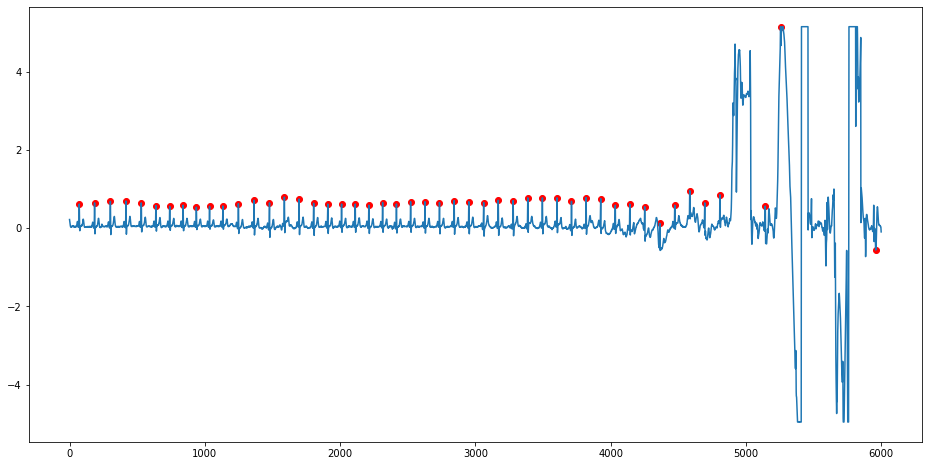

In [74]:
## validation - ECG
caseid = 927

vals = np.load(f'{file_path}/{caseid}.npz')
inp = vals['nECG']

#min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)

ecg_peak = arr.detect_qrs(pd.DataFrame(inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
ecg_peak = sorted(list(set(ecg_peak)))


fig = plt.figure(figsize=(16,8))

plt.plot(inp)
plt.scatter(ecg_peak, inp[ecg_peak], color = 'r')

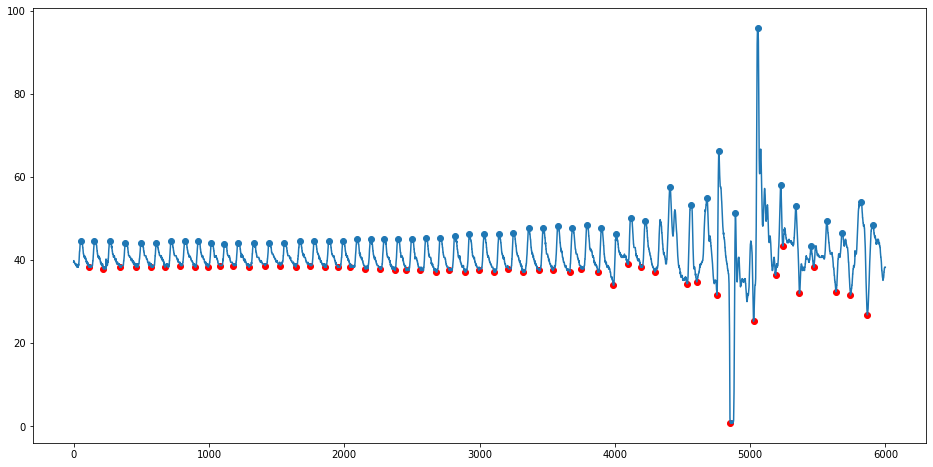

In [75]:
# validation - PPG
caseid = 927

vals = np.load(f'{file_path}/{caseid}.npz')
inp = vals['nPPG']

min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(inp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)


fig = plt.figure(figsize=(16,8))

plt.plot(inp)
plt.scatter(min_peak, inp[min_peak], color = 'r')
plt.scatter(ppg_peak, inp[ppg_peak])

In [84]:

vals = np.load(f'{file_path}/{caseid}.npz')
seg_ecg = vals['nECG']
seg_ppg = vals['nPPG']


min_peak, ppg_peak = arr.detect_peaks(pd.DataFrame(seg_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
ecg_peak = arr.detect_qrs(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), SRATE)
ecg_peak = sorted(list(set(ecg_peak)))



# 10초 segment 내의 ppg, ecg peak idx
#seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
idx_ppg_peak = ppg_peak
idx_ecg_peak = ecg_peak


# peak가 HR 30~150 -> 20s - min 10 peaks(HR30)
# peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
if len(idx_ppg_peak)<5/10*LEN_INPUT or len(idx_ecg_peak)<5/10*LEN_INPUT:
    df_preprocess.loc[f_num-1,'1'] = (False, nan_info, [-2, -2])
    print(' too less peaks', end='')
    


# 20초 segment 내의 ppg, ecg peak value
#print(len(seg_ppg), idx_ppg_peak)
val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]

# peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]


#  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
for k in range(len(bool_noise_ppg)):
    if not 0.4*SRATE < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 2*SRATE:
        bool_noise_ppg[k] = True
for k in range(len(bool_noise_ecg)):
    if not 0.4*SRATE < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 2*SRATE:
        bool_noise_ecg[k] = True


# 2.2 모양 이상한 noise
# wave interval into same length(2s(200))
len_wave = 2*SRATE
norm_seg_ppg, norm_seg_ecg = [], []

for k in range(len(bool_noise_ppg)):
    len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]

    # peak 사이 wave를 모두 같은 길이로 변환
    norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])

for k in range(len(bool_noise_ecg)):
    len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]

    # peak 사이 wave를 모두 같은 길이로 변환
    norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])


# wave interval 사이 correlation 계산 - PPG
mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
for k in range(len(bool_noise_ppg)):
    if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.9:
        bool_noise_ppg[k] = True
noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)

# wave interval 사이 correlation 계산 - ECG                
mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
for k in range(len(bool_noise_ecg)):
    if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.9:
        bool_noise_ecg[k] = True
noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)

# segment의 noise 비율 정보
noise_info = [noise_ppg_perc, noise_ecg_perc]

# segment를 input으로 써도 되는지
if nan_ppg_perc < 0.05 and nan_ecg_perc < 0.05 and nan_both_perc < 0.05 and noise_ppg_perc < 0.1 and noise_ecg_perc < 0.1:
    bool_pass = True
else:
    bool_pass = False

# 이 segment의 정보를 dataframe에 저장 - (전처리 성공여부, 전처리 nan 비율, 전처리 noise 비율, 통증 점수)
arry = np.empty(1, dtype=object)
arry[0] = [bool_pass, nan_info, noise_info]
print(f'caseid {caseid} : {arry[0]}')
print('preprocessing done...', end='')

0.8208548405715844
0.7935421472579829
0.7438409164867248
0.80425047462442
0.8094949000154135
0.7722855589962822
0.8004196101624942
0.8113791201916903
0.7938491244373561
0.8313928965135505
0.727460207840059
0.8211404756332494
0.758698709545385
0.6919648061656924
0.6987152855875413
0.7996069219951678
0.8314868150961645
0.8016791949729699
0.7959025321872977
0.7909129814246891
0.8287999525582017
0.7909877596491521
0.8536242384542043
0.8253990203707388
0.8414899295695085
0.8245985619671797
0.8037166301711326
0.8041330614214733
0.7691722221958732
0.767806297868252
0.7394860388591257
0.7603522092028313
0.788129612152147
0.719269744295907
0.8265072716821742
0.8190156976484699
0.7526085132416165
0.5801194689232436
0.4484414011232797
0.304350592402404
0.32571069105120837
0.7545670584550838
0.5860421586753016
0.5795407163868972
-0.09465287411919637
0.319394802933113
0.6124402573690532
caseid 927 : [False, [0.0, 0.0, 0.0], [0.25, 1.0]]
preprocessing done...

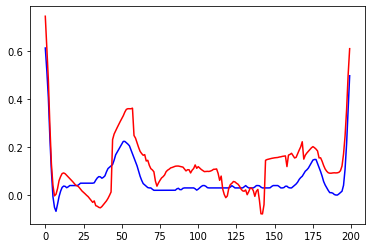

In [85]:
plt.plot(norm_seg_ecg[0], c='b')
plt.plot(mean_wave_ecg, c='r')

In [ ]:
auto-correlation

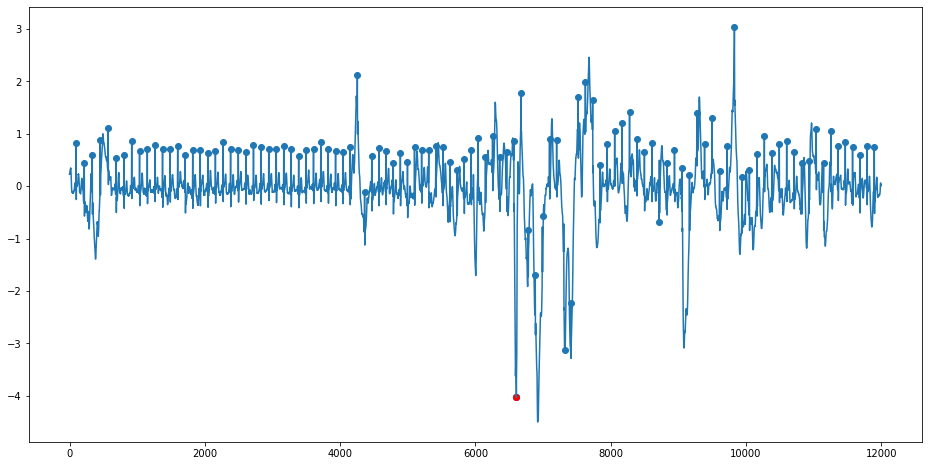

In [43]:
import matplotlib.pyplot as plt


y = pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()


fig = plt.figure(figsize=(16,8))
plt.plot(y)
plt.scatter(ecg_peak, y[ecg_peak])
plt.scatter(6606, y[6606], color = 'r')